# Проект модуля 2: Разведывательный анализ данных.

Цель: отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

Для достижения цели необходимо построить модель, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы. Для этого необходимо проанализировать имеющийся набор данных и выявить закономерности. 

In [333]:
# подключаем необходимые для работы модули
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
# from pylab import *

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

In [334]:
# загружаем набор фактических данных, на оснве которого будем выполнять поиск закономерностей
students = pd.read_csv('stud_math.csv')

In [335]:
# посмотрим, что содержится в наборе
students.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

In [336]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [337]:
# посмотрим на количество неустановленных значений в столбцах
print(f'Количество неустановленных значений (NaN) в столбцах: \n')
students.isnull().sum().sort_values(ascending = False)

Количество неустановленных значений (NaN) в столбцах: 



Pstatus                45
paid                   40
famsup                 39
Fjob                   36
internet               34
romantic               31
guardian               31
traveltime             28
famsize                27
famrel                 27
Fedu                   24
failures               22
higher                 20
Mjob                   19
reason                 17
address                17
nursery                16
health                 15
activities             14
absences               12
freetime               11
schoolsup               9
goout                   8
studytime               7
studytime, granular     7
score                   6
Medu                    3
age                     0
sex                     0
school                  0
dtype: int64

In [338]:
print(f'В {students.isnull().any().sum()} столбцах содержатся неустановленные записи.')

В 27 столбцах содержатся неустановленные записи.


### Общие сведения:
У нас в наборе данных 395 строк с данными в 30-ти столбцах (измерениях). 

Самое большое количество неустановленных значений в поле Pstatus - 45, это 11% от общего массива данных. Считаем, что это не больше количество строк с пропусками и набор данных является хорошим для последующего анализа. Т.к количество пустых строк не велико, то не будем выбрасывать строки, содержащие пустые значения. 

### Первичный анализ структуры и форматов данных:
1. Eсть непонятное поле "studytime, granular", которого нет в описании полей набора данных. Чуть позже постараемся угадать, что же оно значит (выявили ниже).
2. Есть поля с типом float64, которе по сути являются не вещественными, а целыми -> эти поля можно преобразовать в целые для удобства работы. Преобразования типов следует проводить с должной осмотрительностью, т.к. многие из полей содержат неопределенные значения (NaN). Список полей для преобразования в целые: Medu, Fedu, traveltime, studytime, failures, famrel, freetime, goout, health, absences.


#### Посмотрим, что находится в стобцах

In [339]:
# создадим вспомогательные процедуры для упрощения однотипной работы с различными столбцами набора данных

In [340]:
def show_column_info(column):
    """ вспомогательная функция вывода информации по одному столбцу 
        вход: column - наименование столбца
        весь вывод производится на экран (в блокнот jupiter)
    """
    print(f'===== Анализируем столбец: {column} =====\n')
    print(f'тип столбца: {students[column].dtype}\n')
    if students[column].nunique() < 20:
        print(f'Уникальные значания:\n{students[column].value_counts()}')
    else:
        print(f'Уникальных значаний:{students[column].nunique()}')
    
    # не установленные значения (NaN):
    nans = students[column].isna().sum()
    if nans > 0:
        print(f'\nКоличество пропущенных значений (NaN): {nans}  или {nans/len(students)*100:0.2f}%\n')
    
    # Для числовых полей проведем более глубокий анализ
    if students[column].dtype in ['float64', 'int64', 'int32']:
        # если в наборе данных достаточно много уникальных значений, то 
        # вычислим квантили, IQR и оценим наличие выбросов
        if students[column].nunique() > 5:
            print(students[column].describe())
            perc25 = students[column].quantile(0.25)
            perc75 = students[column].quantile(0.75)
            IQR = perc75 - perc25
            range_min_value = perc25 - 1.5*IQR
            range_max_value = perc75 + 1.5*IQR
            outlets_count = len(students[((students[column] < range_min_value) | (students[column] > range_max_value))])
            print(f'\nОценка выбросов:\n25-й перцентиль: {perc25:0.2f}, 75-й перцентиль: {perc75:0.2f}, IQR: {IQR:0.2f}')
            print(f'Границы выбросов: [{range_min_value:0.2f}, {range_max_value:0.2f}]')
            if outlets_count > 0:
                print(f"Есть выбросы по формальному критерию. {outlets_count} значений находятся за пределом расчетного диапазона.")
            else:
                print("Выбросы не обнаружены.\n")

            # строим графики - distplot и boxplot для наглядности восприятия данных
            sns.set(rc={"figure.figsize": (14, 8)});
            subplot(2,2,1)
            ax = sns.distplot(students[column])
            subplot(2,2,2)
            ax = sns.boxplot(students[column])
        else:
            students[column].hist(figsize = (4,3))
    return 0

In [341]:
# Можно было бы запустить вызов функции в цикле, 
#
# for col in students.columns:
#    show_column_info(col)
#
# но тогда весь вывод в Юпитере в небольшом блоке с большой полосой прокрутки, что очень не наглядно

# поэтому для наглядности будем вызывать функцию для каждого измерения (столбца данных)

In [342]:
def show_nominative_plots(column):
    """ вспомогательная функция опрятного вывода графика Boxplot
        для значений столца column и балла по математике (score)
        вход: column - наименование столбца набора данных
        весь вывод производится на экран (в блокнот jupiter)
    """
    fig, ax = plt.subplots(figsize = (8, 4))
    sns.boxplot(x=column, y='score', 
    data=students[[column, 'score']],ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [343]:
def get_stat_dif(column):
    """ вспомогательная функция поиcка статистически значимой зависимости
        между стобцом column и баллом по математике
        вход: column - наименование столбца
        весь вывод производится на экран (в блокнот jupiter)
    """
    cols = students.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    found_diff = False
    for comb in combinations_all:
        if ttest_ind(students.loc[students.loc[:, column] == comb[0], 'score'], 
                     students.loc[students.loc[:, column] == comb[1], 'score']).pvalue <= 0.05/len(combinations_all): 
            print('Найдены статистически значимые различия для колонки', column)
            found_diff = True
            break
    if not found_diff:
        print('НЕ найдены статистически значимые различия для колонки', column)

In [344]:
def show_nominative_column_info(column):
    """ функция вывода информации по столбцу номинативных данных column
        для упрощения работы - чтобы каждый раз не писать в коде три строки с вызовом трёх разных функций
        вход: column - наименование столбца
        весь вывод производится на экран (в блокнот jupiter)
    """    
    show_column_info(column)
    show_nominative_plots(column)
    get_stat_dif(column)

### Анализ столбцов набора данных

===== Анализируем столбец: score =====

тип столбца: float64

Уникальные значания:
50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
40.0     31
60.0     31
70.0     27
45.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64

Количество пропущенных значений (NaN): 6  или 1.52%

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

Оценка выбросов:
25-й перцентиль: 40.00, 75-й перцентиль: 70.00, IQR: 30.00
Границы выбросов: [-5.00, 115.00]
Выбросы не обнаружены.



0

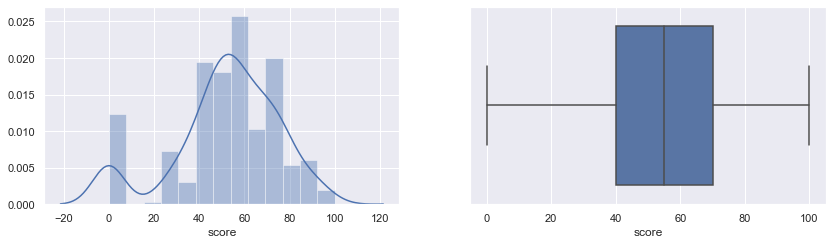

In [345]:
# начинаем с основного столбца 'score'
show_column_info('score')

#### столбец score - баллы по госэкзамену по математике
Самый важный столбец. 
* Числовое поле. Шаг баллов - пять, скорее всего использовались такие тесты, при которых за один правильный отчет не получить меньше 5-ти баллов. 
* Тип поля float64 - вещественный, наверное, имеет смысл преобразовать поле к целому типу данных. 
* Есть несущественные пропуски в данных - отсутствует 6 оценок или 1.5% от общего набора данных. 
Кроме того, у 37-ми студенов стоит 0 баллов, что скорее всего говорит о том, что экзамен они не сдавали (т.к. следующий минимальный балл - 20, и если бы эти студенты сдавали бы экзамен, то скорее были бы не только нулевые баллы, но и баллы 5, 10, 15). Будем считать, что эти студенты или не были допущены до экзамена или на экзамен не явились, не зависимо от причины получения 0 баллов, эта информация является важной для анализа.

##### Поскольку это самый важный для анализа столбец, то от неустановленных значений следует избавиться (удалить их из набора данных), а нулевые значения оставить, т.к. в хоте анализа может выясниться, что, например, студенты из такой-то группы обладают повышенным риском быть недопущенными до экзамена. 


In [346]:
# чистим столбец 'score' - удаляем пустые данные и преобразуем к целому.
students.dropna(subset=['score'], inplace=True) # students['score'].dropna()
# students['score'] = students['score'].astype('int32')

===== Анализируем столбец: age =====

тип столбца: int64

Уникальные значания:
16    103
17     98
15     82
18     80
19     21
20      3
22      1
21      1
Name: age, dtype: int64
count    389.000000
mean      16.673522
std        1.265662
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

Оценка выбросов:
25-й перцентиль: 16.00, 75-й перцентиль: 18.00, IQR: 2.00
Границы выбросов: [13.00, 21.00]
Есть выбросы по формальному критерию. 1 значений находятся за пределом расчетного диапазона.


0

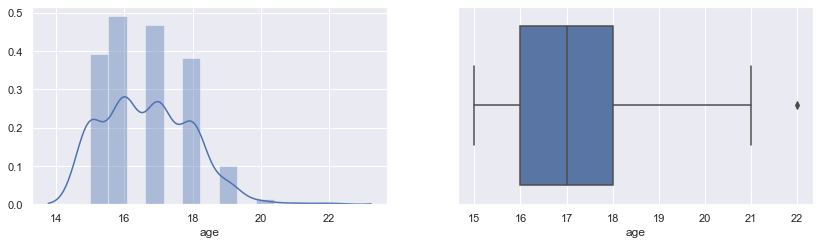

In [347]:
show_column_info('age')

##### столбец Age - возраст
Числовое поле, пропусках в данных нет, возраст студентов от 15-ти до 22-х лет. 
Несмотря на то, что значение 22 подходит под критерии выброса, это поле (скорее всего) не является выбросом, Видимо, один из студентов позже начал учебу или брал академический отпуск (например, из-за болезни). 
Можно было бы преобразовать к типу int32 (для экономии памяти).

In [348]:
# students['age'] = students['age'].astype('int32')

===== Анализируем столбец: absences =====

тип столбца: float64

Уникальных значаний:36

Количество пропущенных значений (NaN): 11  или 2.83%

count    378.000000
mean       7.320106
std       23.615525
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

Оценка выбросов:
25-й перцентиль: 0.00, 75-й перцентиль: 8.00, IQR: 8.00
Границы выбросов: [-12.00, 20.00]
Есть выбросы по формальному критерию. 17 значений находятся за пределом расчетного диапазона.


0

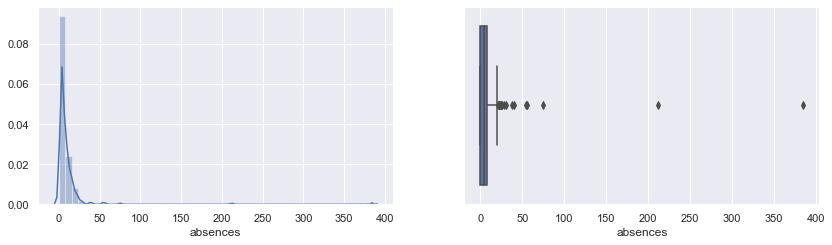

In [349]:
show_column_info('absences')

#### столбец absences -количество пропущенных занятий
* Числовое поле.  
* Есть несущественные пропуски в данных - отсутствует 12 оценок или 3% от общего набора данных. 
* Несмотря на то, что 17 значений подходят под формальные критерии выброса, они не являются выбросами, Видимо, некоторые студенты много болели. 
* Тип столбца - вещественный float64, Можно преобразовать к целому типу int32 (для экономии памяти).

## Посмотрим, есть ли корреляция между числовыми (не номинативными) характеристиками

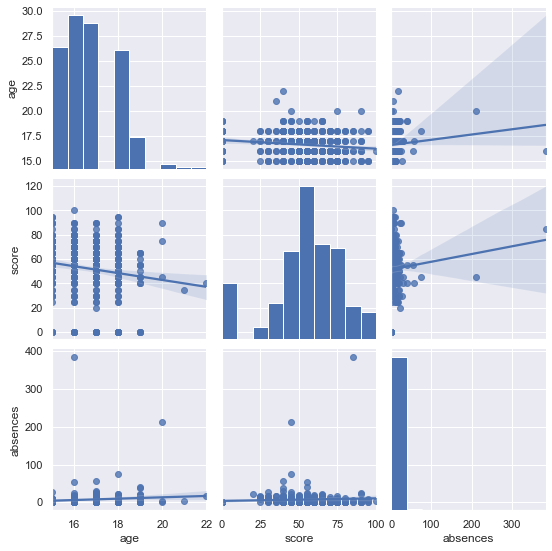

In [350]:
sns.pairplot(students[['age', 'score', 'absences']], kind = 'reg')

In [351]:
students[['age', 'score', 'absences']].corr()

,age,score,absences
age,1.000000,-0.155726,0.096628
score,-0.155726,1.000000,0.065283
absences,0.096628,0.065283,1.000000


### Промежуточный вывод: однозначная связь между численными не номинативными характеристиками не прослеживается

===== Анализируем столбец: sex =====

тип столбца: object

Уникальные значания:
F    204
M    185
Name: sex, dtype: int64


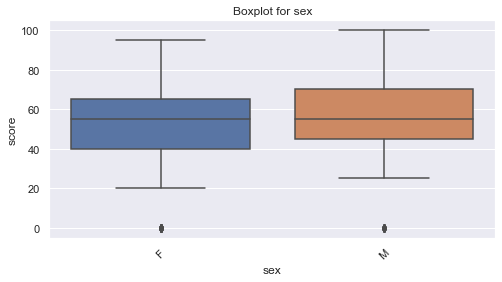

НЕ найдены статистически значимые различия для колонки sex


In [352]:
show_nominative_column_info('sex')

#### столбец sex — пол ученика ('F' - женский, 'M' - мужской)
* Пропусков в данных нет, два уникальных значения (мальчики и девочки).
* У мальчиков в этой выборке дела с математикой обстоят чуть лучше, чем у девочек, но это ничего еще не значит, т.к. различия статистически не значимы.

===== Анализируем столбец: school =====

тип столбца: object

Уникальные значания:
GP    344
MS     45
Name: school, dtype: int64


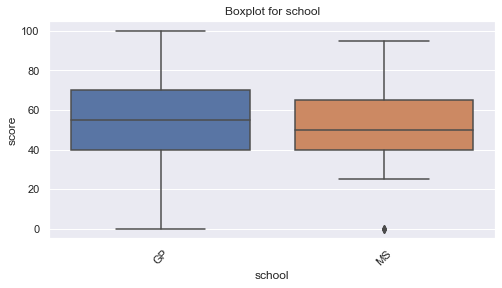

НЕ найдены статистически значимые различия для колонки school


In [353]:
show_nominative_column_info('school')

#### столбец school — аббревиатура школы, в которой учится ученик
* Пропусков в данных нет, два уникальных значения.
* в школе GP средний бал по математике выше, чем в школе MS, но это ничего еще не значит, т.к. различия статистически не значимы.

===== Анализируем столбец: address =====

тип столбца: object

Уникальные значания:
U    291
R     83
Name: address, dtype: int64

Количество пропущенных значений (NaN): 15  или 3.86%



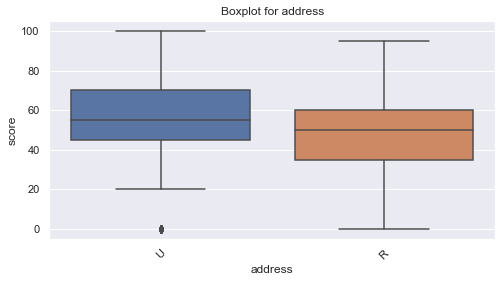

Найдены статистически значимые различия для колонки address


In [354]:
show_nominative_column_info('address')

#### столбец address — тип адреса ученика ('U' - городской, 'R' - за городом)
* Пропуски в данных не значительные = 3.9%.
* Есть существенные статистические различия между школьниками, живущими в городе и за городом. Городские школьники, в среднем, получают более высокий балл по математике, чем школьники, живущие за городом.

===== Анализируем столбец: famsize =====

тип столбца: object

Уникальные значания:
GT3    255
LE3    107
Name: famsize, dtype: int64

Количество пропущенных значений (NaN): 27  или 6.94%



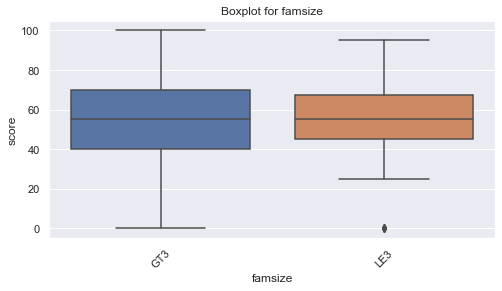

НЕ найдены статистически значимые различия для колонки famsize


In [355]:
show_nominative_column_info('famsize')

#### столбец famsize — размер семьи('LE3' <= 3, 'GT3' >3)
* Пропуски в данных не значительные, менее 7%.
* Статистически значимой зависимости балла по математике от размера семьи не выявлено.

===== Анализируем столбец: Pstatus =====

тип столбца: object

Уникальные значания:
T    308
A     36
Name: Pstatus, dtype: int64

Количество пропущенных значений (NaN): 45  или 11.57%



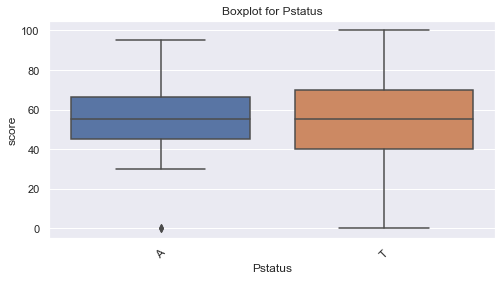

НЕ найдены статистически значимые различия для колонки Pstatus


In [356]:
show_nominative_column_info('Pstatus')

#### столбец Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)
* Пропуски в данных не значительные, менее 12%.
* Статистически значимой зависимости балла по математике от статуса совместного проживания родителей не выявлено.

===== Анализируем столбец: Medu =====

тип столбца: float64

Уникальные значания:
4.0    131
2.0    100
3.0     96
1.0     56
0.0      3
Name: Medu, dtype: int64

Количество пропущенных значений (NaN): 3  или 0.77%



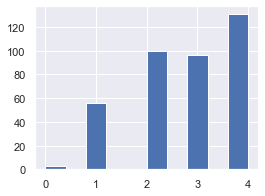

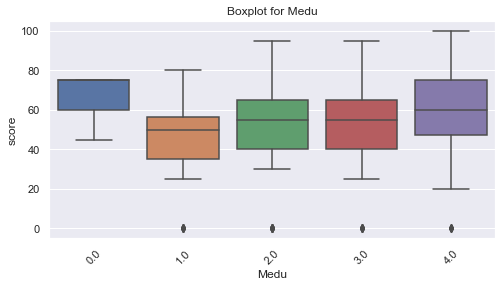

Найдены статистически значимые различия для колонки Medu


In [357]:
show_nominative_column_info('Medu')

#### столбец Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
* Пропуски в данных не значительные, менее 1%.
* Есть статистически значимая зависимость балла по математике от образования матери. У более образованных матерей дети получают больший балл. Есть одно интересное исключение: если у матери нет образования, то их дети получают высокие баллы, правда, таких всего три человека. 

===== Анализируем столбец: Fedu =====

тип столбца: float64

Уникальные значания:
2.0     105
3.0      94
4.0      88
1.0      75
0.0       2
40.0      1
Name: Fedu, dtype: int64

Количество пропущенных значений (NaN): 24  или 6.17%

count    365.000000
mean       2.627397
std        2.241790
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max       40.000000
Name: Fedu, dtype: float64

Оценка выбросов:
25-й перцентиль: 2.00, 75-й перцентиль: 3.00, IQR: 1.00
Границы выбросов: [0.50, 4.50]
Есть выбросы по формальному критерию. 3 значений находятся за пределом расчетного диапазона.


0

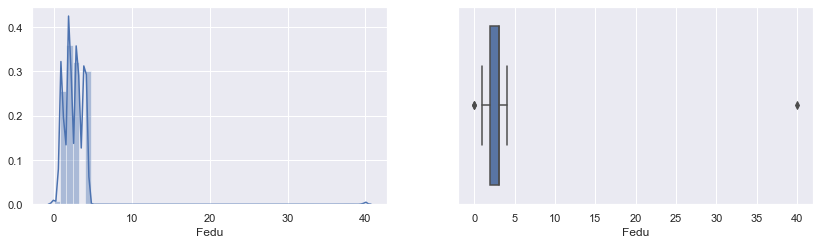

In [358]:
show_column_info('Fedu')

#### столбец Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
Есть одно значение Fedu = 40, которое явно за пределами допустимых значений. Осмелюсь предположить, что это просто ошибка в данных и на самомо деле должно быть не 40, а 4. Исправим эту неточность и проведем анализ поля еще раз.

In [359]:
# исправим значения, Fedu=40 превратим в Fedu=4.
students['Fedu'] = students['Fedu'].apply(lambda x: x if x != 40 else 4)

===== Анализируем столбец: Fedu =====

тип столбца: float64

Уникальные значания:
2.0    105
3.0     94
4.0     89
1.0     75
0.0      2
Name: Fedu, dtype: int64

Количество пропущенных значений (NaN): 24  или 6.17%



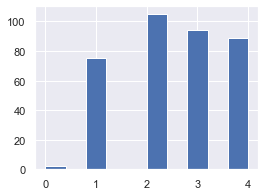

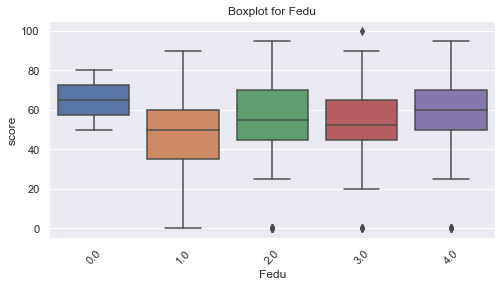

НЕ найдены статистически значимые различия для колонки Fedu


In [360]:
show_nominative_column_info('Fedu')

#### столбец Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
* Пропуски в данных не значительные, менее 6.2%.
* Статистически значимой зависимости балла по математике от образования отца не выявлено.

===== Анализируем столбец: Mjob =====

тип столбца: object

Уникальные значания:
other       127
services     98
at_home      58
teacher      55
health       32
Name: Mjob, dtype: int64

Количество пропущенных значений (NaN): 19  или 4.88%



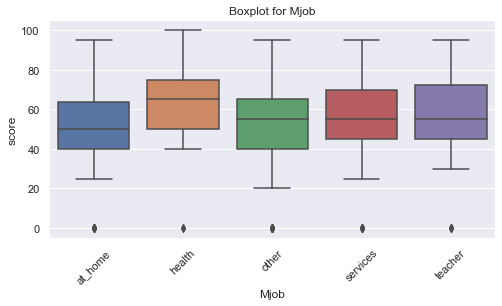

Найдены статистически значимые различия для колонки Mjob


In [361]:
show_nominative_column_info('Mjob')

#### столбец Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
* Пропуски в данных не значительные, менее 5%.
* Есть статистически значимая зависимость балла по математике от работы матери. В частности, дети матерей, занятых в системе здравоохранения получают больший балл по математике, чем дети домохозяек.

===== Анализируем столбец: Fjob =====

тип столбца: object

Уникальные значания:
other       194
services     99
teacher      29
at_home      16
health       15
Name: Fjob, dtype: int64

Количество пропущенных значений (NaN): 36  или 9.25%



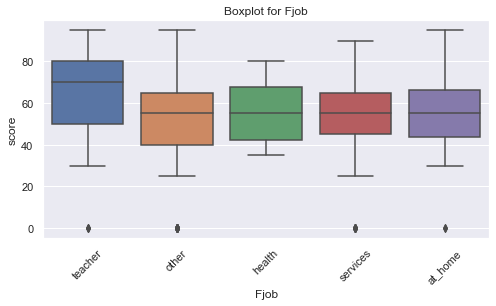

НЕ найдены статистически значимые различия для колонки Fjob


In [362]:
show_nominative_column_info('Fjob')

#### столбец Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
* Пропуски в данных не значительные, менее 10%.
* Статистически значимой зависимости балла по математике от работы отца не выявлено.

===== Анализируем столбец: reason =====

тип столбца: object

Уникальные значания:
course        135
reputation    102
home          101
other          34
Name: reason, dtype: int64

Количество пропущенных значений (NaN): 17  или 4.37%



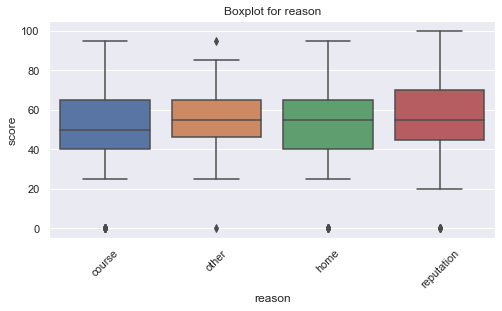

НЕ найдены статистически значимые различия для колонки reason


In [363]:
show_nominative_column_info('reason')

#### столбец reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)
* Пропуски в данных не значительные, менее 5%.
* Статистически значимой зависимости балла по математике от причины выбора школы не выявлено.

===== Анализируем столбец: guardian =====

тип столбца: object

Уникальные значания:
mother    248
father     86
other      24
Name: guardian, dtype: int64

Количество пропущенных значений (NaN): 31  или 7.97%



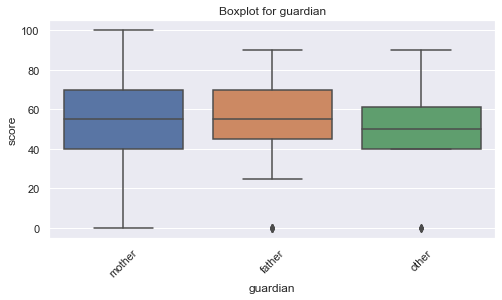

НЕ найдены статистически значимые различия для колонки guardian


In [364]:
show_nominative_column_info('guardian')

#### столбец guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)
* Пропуски в данных не значительные, менее 8%.
* Статистически значимой зависимости балла по математике от опекуна не выявлено.

===== Анализируем столбец: traveltime =====

тип столбца: float64

Уникальные значания:
1.0    239
2.0     94
3.0     21
4.0      7
Name: traveltime, dtype: int64

Количество пропущенных значений (NaN): 28  или 7.20%



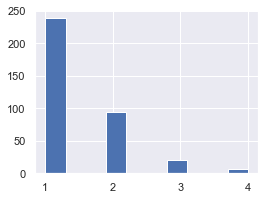

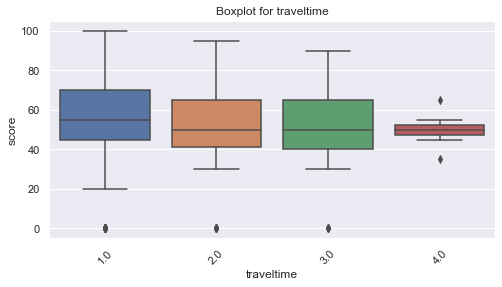

НЕ найдены статистически значимые различия для колонки traveltime


In [365]:
show_nominative_column_info('traveltime')

#### столбец traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)
* Пропуски в данных не значительные, менее 8%.
* Статистически значимой зависимости балла по математике от времени в пути до школы не выявлено.

===== Анализируем столбец: studytime =====

тип столбца: float64

Уникальные значания:
2.0    189
1.0    103
3.0     63
4.0     27
Name: studytime, dtype: int64

Количество пропущенных значений (NaN): 7  или 1.80%



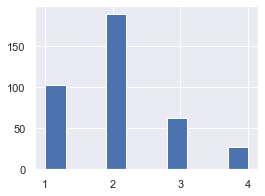

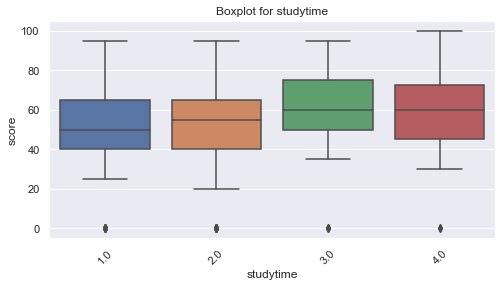

НЕ найдены статистически значимые различия для колонки studytime


In [366]:
show_nominative_column_info('studytime')

#### столбец studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)
* Пропуски в данных не значительные, менее 7%.
* Статистически значимой зависимости балла по математике от времени на учебу помимо школы не выявлено.

===== Анализируем столбец: studytime, granular =====

тип столбца: float64

Уникальные значания:
-6.0     189
-3.0     103
-9.0      63
-12.0     27
Name: studytime, granular, dtype: int64

Количество пропущенных значений (NaN): 7  или 1.80%



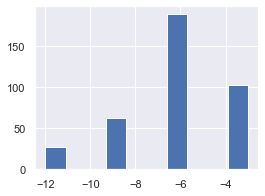

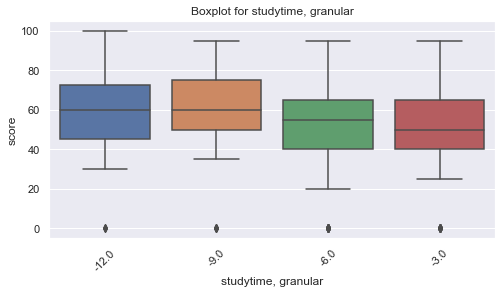

НЕ найдены статистически значимые различия для колонки studytime, granular


In [367]:
show_nominative_column_info('studytime, granular')

#### столбец studytime, granular — описание столбца в базе отсутствует
* Пропуски в данных не значительные, менее 7%.
* Статистически значимой зависимости балла по математике от времени на учебу помимо школы не выявлено.

Посмотрим, как этот столбец связан со столбцом studytime (кроме схожих названий)

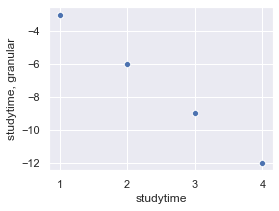

In [368]:
sns.set(rc={"figure.figsize": (4, 3)});
sns.scatterplot(data=students[['studytime', 'studytime, granular']], x='studytime', y='studytime, granular')

#### хорошо видно, что столбец 'studytime, granular'  =  -3  *  'studytime'
видимо, можно его удалить из набора данных

In [369]:
# удаление избыточного столбца 'studytime, granular'из набора данных
# students.drop(columns='studytime, granular', inplace=True)

===== Анализируем столбец: failures =====

тип столбца: float64

Уникальные значания:
0.0    290
1.0     48
2.0     15
3.0     14
Name: failures, dtype: int64

Количество пропущенных значений (NaN): 22  или 5.66%



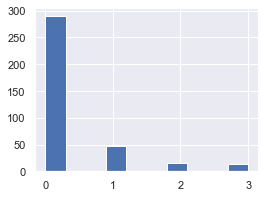

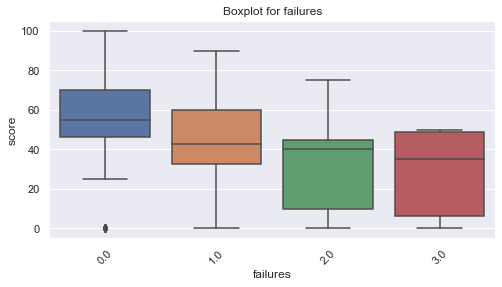

Найдены статистически значимые различия для колонки failures


In [370]:
show_nominative_column_info('failures')

#### столбец failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)
* Пропуски в данных не значительные, менее 6%.
* Выявлена статистически значимая зависимость балла по математике от количества внеучебных неудач. Чем больше внеучебных неудач, тем в среднем ниже балл по математике.

===== Анализируем столбец: schoolsup =====

тип столбца: object

Уникальные значания:
no     331
yes     49
Name: schoolsup, dtype: int64

Количество пропущенных значений (NaN): 9  или 2.31%



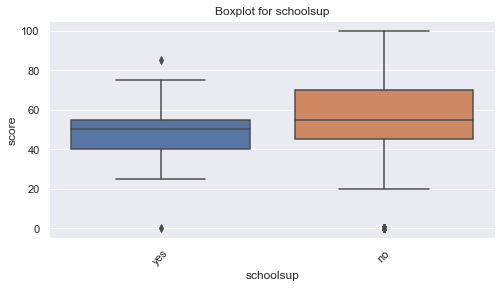

НЕ найдены статистически значимые различия для колонки schoolsup


In [371]:
show_nominative_column_info('schoolsup')

#### столбец schoolsup — дополнительная образовательная поддержка (yes или no)
* Пропуски в данных не значительные, менее 3%.
* Статистически значимой зависимости балла по математике от дополнительной образовательной поддержки не выявлено.

===== Анализируем столбец: famsup =====

тип столбца: object

Уникальные значания:
yes    216
no     135
Name: famsup, dtype: int64

Количество пропущенных значений (NaN): 38  или 9.77%



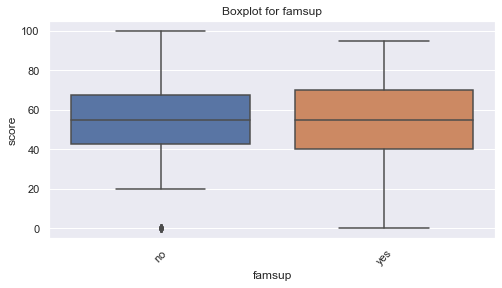

НЕ найдены статистически значимые различия для колонки famsup


In [372]:
show_nominative_column_info('famsup')

#### столбец famsup — семейная образовательная поддержка (yes или no)
* Пропуски в данных не значительные, менее 10%.
* Статистически значимой зависимости балла по математике от семейной образовательной поддержки не выявлено.

===== Анализируем столбец: paid =====

тип столбца: object

Уникальные значания:
no     197
yes    153
Name: paid, dtype: int64

Количество пропущенных значений (NaN): 39  или 10.03%



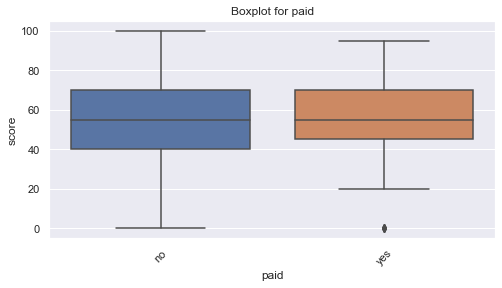

НЕ найдены статистически значимые различия для колонки paid


In [373]:
show_nominative_column_info('paid')

#### столбец paid — дополнительные платные занятия по математике (yes или no)
* Пропуски в данных не значительные, 10%.
* Статистически значимой зависимости балла по математике от наличия дополнительных платных занятий не выявлено.

===== Анализируем столбец: activities =====

тип столбца: object

Уникальные значания:
yes    192
no     183
Name: activities, dtype: int64

Количество пропущенных значений (NaN): 14  или 3.60%



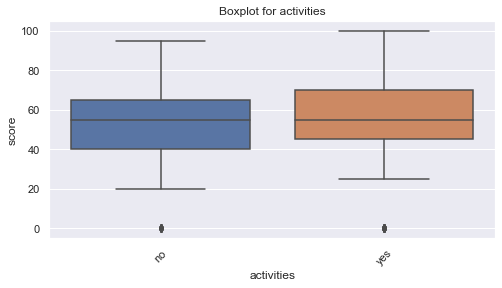

НЕ найдены статистически значимые различия для колонки activities


In [374]:
show_nominative_column_info('activities')

#### столбец activities — дополнительные внеучебные занятия (yes или no)
* Пропуски в данных не значительные, менее 4%.
* Статистически значимой зависимости балла по математике от наличия дополнительных внеучебных занятий не выявлено.

===== Анализируем столбец: nursery =====

тип столбца: object

Уникальные значания:
yes    297
no      77
Name: nursery, dtype: int64

Количество пропущенных значений (NaN): 15  или 3.86%



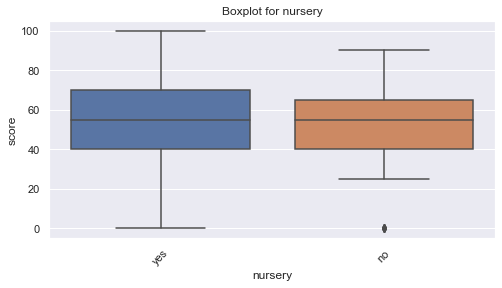

НЕ найдены статистически значимые различия для колонки nursery


In [375]:
show_nominative_column_info('nursery')

#### столбец nursery — посещал детский сад (yes или no)
* Пропуски в данных не значительные, менее 4%.
* Статистически значимой зависимости балла по математике от посещения детского сада не выявлено.

===== Анализируем столбец: higher =====

тип столбца: object

Уникальные значания:
yes    350
no      19
Name: higher, dtype: int64

Количество пропущенных значений (NaN): 20  или 5.14%



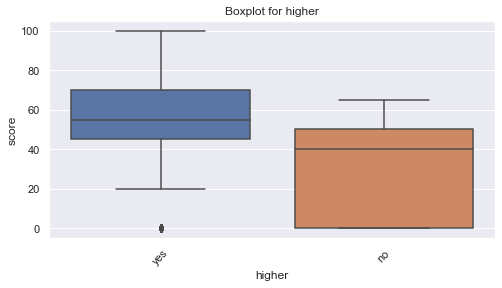

Найдены статистически значимые различия для колонки higher


In [376]:
show_nominative_column_info('higher')

#### столбец higher — хочет получить высшее образование (yes или no)
* Пропуски в данных не значительные, менее 6%.
* Выявлена статистически значимая зависимость балла по математике от желания получить высшее образования. У школьников, которые хотят получить высшее образование балл по математике в среднем выше, чем у школьников, которые не хотят получать высшее образование.

===== Анализируем столбец: internet =====

тип столбца: object

Уникальные значания:
yes    300
no      55
Name: internet, dtype: int64

Количество пропущенных значений (NaN): 34  или 8.74%



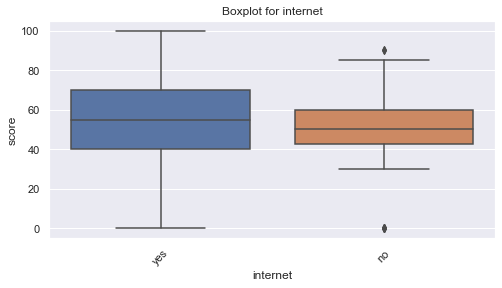

НЕ найдены статистически значимые различия для колонки internet


In [377]:
show_nominative_column_info('internet')

#### столбец internet — наличие интернета дома (yes или no)
* Пропуски в данных не значительные, менее 9%.
* Статистически значимой зависимости балла по математике от наличия дома интернета не выявлено.

===== Анализируем столбец: romantic =====

тип столбца: object

Уникальные значания:
no     235
yes    123
Name: romantic, dtype: int64

Количество пропущенных значений (NaN): 31  или 7.97%



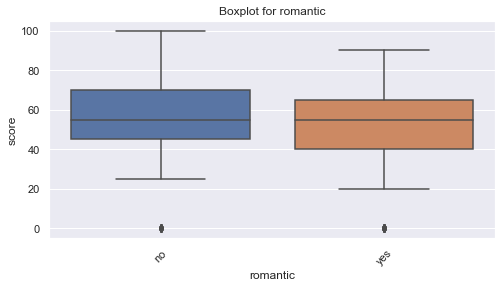

Найдены статистически значимые различия для колонки romantic


In [378]:
show_nominative_column_info('romantic')

#### столбец romantic — в романтических отношениях (yes или no)
* Пропуски в данных не значительные, менее 9%.
* Выявлена статистически значимая зависимость балла по математике от того, состоит ли школьник в романтическиз отношениях. 

===== Анализируем столбец: famrel =====

тип столбца: float64

Уникальные значания:
 4.0    178
 5.0     97
 3.0     62
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64

Количество пропущенных значений (NaN): 27  или 6.94%

count    362.000000
mean       3.930939
std        0.931554
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

Оценка выбросов:
25-й перцентиль: 4.00, 75-й перцентиль: 5.00, IQR: 1.00
Границы выбросов: [2.50, 6.50]
Есть выбросы по формальному критерию. 25 значений находятся за пределом расчетного диапазона.


0

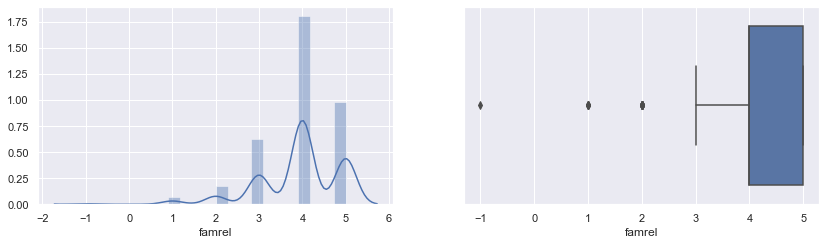

In [379]:
show_column_info('famrel')

#### столбец famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)
* Пропуски в данных не значительные, менее 7%.
* Есть значение famrel = -1, которое выходит за пределы допустимых значений. Сделаем предположение, что это ошибка в данных, и, поскольку мы не можем наверняка утвеждать, что это опечатка или что-то еще, то просто выбросим это значение из рассмотрения.

In [380]:
students['famrel'] = students['famrel'].apply(lambda x: x if x != -1 else np.nan)

===== Анализируем столбец: famrel =====

тип столбца: float64

Уникальные значания:
4.0    178
5.0     97
3.0     62
2.0     17
1.0      7
Name: famrel, dtype: int64

Количество пропущенных значений (NaN): 28  или 7.20%



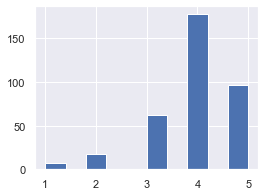

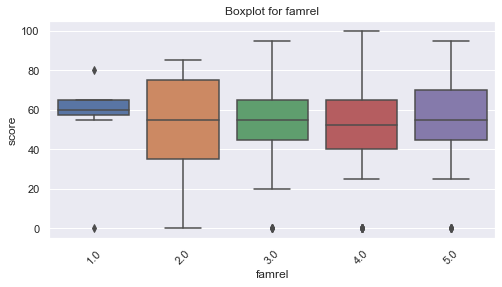

НЕ найдены статистически значимые различия для колонки famrel


In [381]:
show_nominative_column_info('famrel')

#### столбец famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо) - после корректировки данных
* Пропуски в данных не значительные, менее 7%.
* Статистически значимой зависимости балла по математике от семейных отношений не выявлено.

===== Анализируем столбец: freetime =====

тип столбца: float64

Уникальные значания:
3.0    152
4.0    110
2.0     63
5.0     37
1.0     18
Name: freetime, dtype: int64

Количество пропущенных значений (NaN): 9  или 2.31%



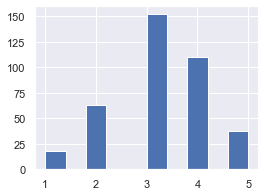

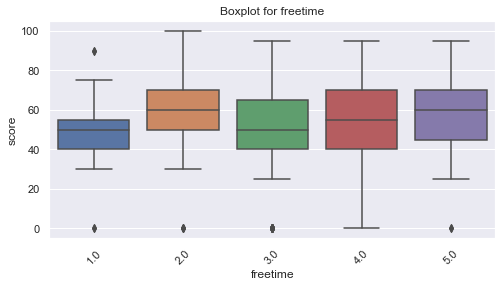

НЕ найдены статистически значимые различия для колонки freetime


In [382]:
show_nominative_column_info('freetime')

#### столбец freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)
* Пропуски в данных не значительные, менее 3%.
* Статистически значимой зависимости балла по математике от количества свободного времени после школы не выявлено.

===== Анализируем столбец: goout =====

тип столбца: float64

Уникальные значания:
3.0    126
2.0    101
4.0     81
5.0     51
1.0     23
Name: goout, dtype: int64

Количество пропущенных значений (NaN): 7  или 1.80%



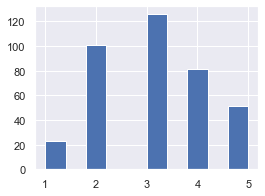

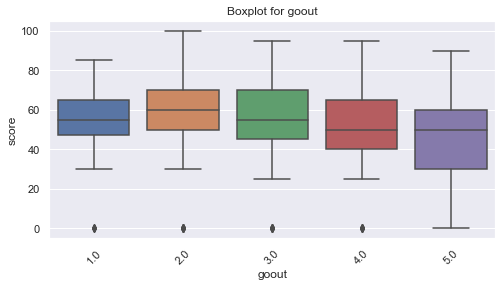

Найдены статистически значимые различия для колонки goout


In [383]:
show_nominative_column_info('goout')

#### столбец goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)
* Пропуски в данных не значительные, менее 2%.
* Выявлена статистически значимая зависимость балла по математике от количества времени, проведенного с друзьями.

===== Анализируем столбец: health =====

тип столбца: float64

Уникальные значания:
5.0    137
3.0     88
4.0     60
1.0     47
2.0     42
Name: health, dtype: int64

Количество пропущенных значений (NaN): 15  или 3.86%



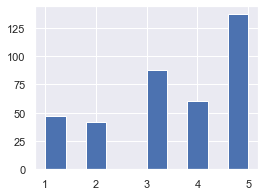

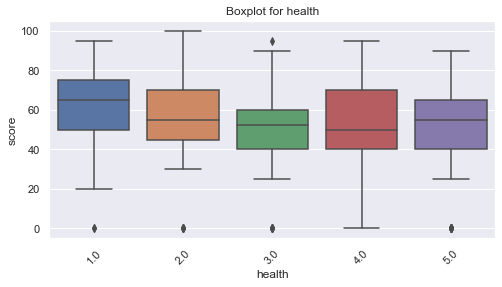

НЕ найдены статистически значимые различия для колонки health


In [384]:
show_nominative_column_info('health')

#### столбец health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)
* Пропуски в данных не значительные, менее 7%.
* Статистически значимой зависимости балла по математике от текущего состояния здоровья не выявлено.

#### Итак, прошли по всем столбцам набора данных, теперь удалим столбцы, которые не влияют на балл по математике и запишем Заключение.

In [385]:
# Столбцы, которые будем удалять из набора данных.
columns_to_drop = ['age', 'absences', 'school', 'sex', 'famsize', 'Pstatus', 'Fedu', 'Fjob', 'reason', 
                   'guardian', 'traveltime', 'studytime', 'studytime, granular', 'schoolsup', 'famsup', 
                   'paid', 'activities', 'nursery', 'famrel', 'freetime', 'health', 'internet']
students.drop(columns=columns_to_drop, inplace=True)

In [386]:
# поля, которые мы оставили для дальнейшей работы с моделью
students.columns

Index(['address', 'Medu', 'Mjob', 'failures', 'higher', 'romantic', 'goout',
       'score'],
      dtype='object')

In [387]:
students.shape

(389, 8)

# Заключение

Набор данных содержал 395 записей в 30-ти столбцах. 

В 25-ти столбцах содержались неустановленные значения. Максимальное количество неустановленных значений содержалось в столбце Pstatus — статусе совместного жилья родителей - 45 неустановленных записей или 11.6%. Считаем, что количество неустановленных записей является не значительным и не скажется на качестве итоговой модели. 

Основной столбец Score - балл госэкзамена по математике - так же содержал 6 (шесть) неустановленных значений или 1.5% от общего набора данных. Т.к. мы исследуем зависимость полученного балла по математике на экзамене от других параметров, то это поле не может быть неопределенным. Следовательно, строки с неустановленными значениями было решено удалить из набора.

Кроме того, столбец, Score со значениями балла по математике содержит нулевые значения - эти данные было решено оставить, т.к. 0 баллов может свидетельствовать о том, что школьник не был допущен до экзамена или не явился на него и это важная информация для анализа т.к. в ходе анализа мы пытаемся выявить факторы, которые не позволяют школьнику получить высокий балл, а недопуск или не сдача экзамена как раз является одним из таких событий, которые надо уметь предсказывать.

В ходе изучения данных был выявлен столбец 'studytime, granular', который отсутствовал в описании набора данных. Дополнительный анализ показал, что это поле является зависимым от поля 'studytime' (связано с ним формулой 'studytime, granular' = -3 * 'studytime'). Зависимости балла по математике от значений поля 'studytime, granular' - не выявлено. 

Кроме того, при анализе значений характеристик, были обнаружены несоответствия с описанием, в частности:
* в поле Fedu образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее) - было обнаружено значение 40, которое, скорее всего, является опечатной и исправлено на 4.
* в поле famrel семейные отношения (от 1 - очень плохо до 5 - очень хорошо) было обнаружено значение -1, которое признано ошибкой и изменено на неустановленное значение NaN.

В ходе корелляционного анализа не было найдено связи между числовыми полями 'age'(возрастом), 'absences'(количеством пропусков) и баллом по математике.

При анализе номинативных характеристик с применением теста Стьюдента было выяслено наличие статистически значимой зависимости балла по математики от следующих полей:
* address (тип адреса ученика) 
* Medu ( образование матери) 
* Mjob (работа матери)
* failures (количество внеучебных неудач)
* romantic (наличие романтических отношений)
* goout (проведение времени с друзьями)
* higher (желания получить высшее образование)

Остальные поля, для облегчения модели и последующего анализа были удалены из итогового надора данных. 

В наборе данных после разведывательного анализа содержится 389 записей в 8-ми столбцах